## Лабораторная работа №4
    ФИО: Михайлов Александр Евгеньевич
    Группа: БИВТ-23-СП-1

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('student-mat.csv', sep=',')

### 2. Определение типа задачи машинного обучения

**Целевая переменная:** `G3` — итоговая оценка студентов (0-20 баллов)

**Тип задачи:** МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ

**Обоснование:** 
- Предсказываем одну из 21 возможной категории (оценки от 0 до 20)
- Каждая оценка - это отдельный класс, а не непрерывное число
- Студент может получить только одну итоговую оценку
- **упростим здачу до 3 сновных классов где оценка 0-6 плохо, 7-13 хорошо, 14-20*

### 3. Предобработка данных

In [2]:
# Загрузка данных

# 1. Создание целевой переменной с 3 классами
def create_grade_class(grade):
    if grade <= 6:
        return 0  # "плохо"
    elif grade <= 13:
        return 1  # "хорошо"
    else:
        return 2  # "отлично"

df['grade_class'] = df['G3'].apply(create_grade_class)

# 2. Разделение на признаки и целевую переменную
X = df.drop(['G3', 'grade_class'], axis=1)
y = df['grade_class']

# 3. Разделение на train/test с стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Стратификация по классам
)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Распределение классов в train: {pd.Series(y_train).value_counts().sort_index()}")
print(f"Распределение классов в test: {pd.Series(y_test).value_counts().sort_index()}")

# 4. Разделение на числовые и категориальные признаки
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

print(f"\nЧисловые колонки: {len(numeric_cols)}")
print(f"Категориальные колонки: {len(categorical_cols)}")

# 5. Обработка числовых признаков (нормализация)
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_numeric = scaler.transform(X_test[numeric_cols])

# 6. Обработка категориальных признаков (One-Hot Encoding)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_categorical = encoder.fit_transform(X_train[categorical_cols])
X_test_categorical = encoder.transform(X_test[categorical_cols])

# Объединение признаков
X_train_processed = np.concatenate([X_train_numeric, X_train_categorical], axis=1)
X_test_processed = np.concatenate([X_test_numeric, X_test_categorical], axis=1)



Размер тренировочной выборки: (316, 32)
Размер тестовой выборки: (79, 32)
Распределение классов в train: grade_class
0     49
1    187
2     80
Name: count, dtype: int64
Распределение классов в test: grade_class
0    12
1    47
2    20
Name: count, dtype: int64

Числовые колонки: 15
Категориальные колонки: 17


### 4. Создание Dataset и DataLoader

In [3]:
# 1. Преобразуем данные в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)  # ДОБАВИЛИ dtype
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)        # ДОБАВИЛИ dtype
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)    # ИСПРАВИЛИ: X_test_processed вместо X_train_processed
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)   

print(f"Размерность X_train_tensor: {X_train_tensor.shape}")  # [316, 58]
print(f"Размерность y_train_tensor: {y_train_tensor.shape}")  # [316]
print(f"Размерность X_test_tensor: {X_test_tensor.shape}")    # [79, 58]
print(f"Размерность y_test_tensor: {y_test_tensor.shape}")    # [79]

# 2. Использование TensorDataset (простой способ)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 3. Создаем DataLoader (используем первый способ для простоты)
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,        # перемешиваем тренировочные данные
    num_workers=0        # для стабильности в Colab/Jupyter
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,       # тестовые данные не перемешиваем
    num_workers=0
)

# 4. Проверяем работу DataLoader
print("\n" + "="*50)
print("ПРОВЕРКА DATALOADER")
print("="*50)

# Проверяем один батч
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Батч {batch_idx + 1}:")
    print(f"  Размер features: {data.shape}")    # [32, 58]
    print(f"  Размер target: {target.shape}")    # [32]
    print(f"  Тип features: {type(data)}")       # torch.Tensor
    print(f"  Тип target: {type(target)}")       # torch.Tensor
    print(f"  Пример меток в батче: {target[:10]}")  # первые 10 меток
    break  # смотрим только первый батч

# 5. Проверяем размеры датасетов
print(f"\nРазмер train dataset: {len(train_dataset)} примеров")
print(f"Размер test dataset: {len(test_dataset)} примеров")
print(f"Количество батчей в train: {len(train_loader)}")
print(f"Количество батчей в test: {len(test_loader)}")

# 7. Проверяем все батчи (опционально)
print(f"\nРазмеры всех батчей в train:")
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"  Батч {batch_idx + 1}: {data.shape}")

print(f"\nРазмеры всех батчей в test:")
for batch_idx, (data, target) in enumerate(test_loader):
    print(f"  Батч {batch_idx + 1}: {data.shape}")

print("\nDataset и DataLoader созданы успешно!")


Размерность X_train_tensor: torch.Size([316, 58])
Размерность y_train_tensor: torch.Size([316])
Размерность X_test_tensor: torch.Size([79, 58])
Размерность y_test_tensor: torch.Size([79])

ПРОВЕРКА DATALOADER
Батч 1:
  Размер features: torch.Size([32, 58])
  Размер target: torch.Size([32])
  Тип features: <class 'torch.Tensor'>
  Тип target: <class 'torch.Tensor'>
  Пример меток в батче: tensor([1, 2, 1, 1, 1, 2, 1, 0, 1, 0])

Размер train dataset: 316 примеров
Размер test dataset: 79 примеров
Количество батчей в train: 10
Количество батчей в test: 3

Размеры всех батчей в train:
  Батч 1: torch.Size([32, 58])
  Батч 2: torch.Size([32, 58])
  Батч 3: torch.Size([32, 58])
  Батч 4: torch.Size([32, 58])
  Батч 5: torch.Size([32, 58])
  Батч 6: torch.Size([32, 58])
  Батч 7: torch.Size([32, 58])
  Батч 8: torch.Size([32, 58])
  Батч 9: torch.Size([32, 58])
  Батч 10: torch.Size([28, 58])

Размеры всех батчей в test:
  Батч 1: torch.Size([32, 58])
  Батч 2: torch.Size([32, 58])
  Батч 3: t

### 5-6.Обучение нейронных сетей и визуализация кривых обучения

Используется устройство: cpu
ОБУЧЕНИЕ МОДЕЛЕЙ С РЕГУЛЯРИЗАЦИЕЙ

1. SimpleNet + SGD
SimpleNet | Epoch [20/100], Train Loss: 0.6087, Test Loss: 0.6239
SimpleNet | Epoch [40/100], Train Loss: 0.5029, Test Loss: 0.5203
SimpleNet | Epoch [60/100], Train Loss: 0.4474, Test Loss: 0.4681
SimpleNet | Epoch [80/100], Train Loss: 0.4126, Test Loss: 0.4357
SimpleNet | Epoch [100/100], Train Loss: 0.3857, Test Loss: 0.4133

2. MediumNet + Adam
MediumNet | Epoch [20/100], Train Loss: 0.8928, Test Loss: 0.8978
MediumNet | Epoch [40/100], Train Loss: 0.7851, Test Loss: 0.7481
MediumNet | Epoch [60/100], Train Loss: 0.6824, Test Loss: 0.6262
MediumNet | Epoch [80/100], Train Loss: 0.5837, Test Loss: 0.5406
MediumNet | Epoch [100/100], Train Loss: 0.5537, Test Loss: 0.4848

3. ComplexNet + Adam
ComplexNet | Epoch [20/100], Train Loss: 0.9832, Test Loss: 0.9781
ComplexNet | Epoch [40/100], Train Loss: 0.8680, Test Loss: 0.8435
ComplexNet | Epoch [60/100], Train Loss: 0.7439, Test Loss: 0.6814
ComplexNet 

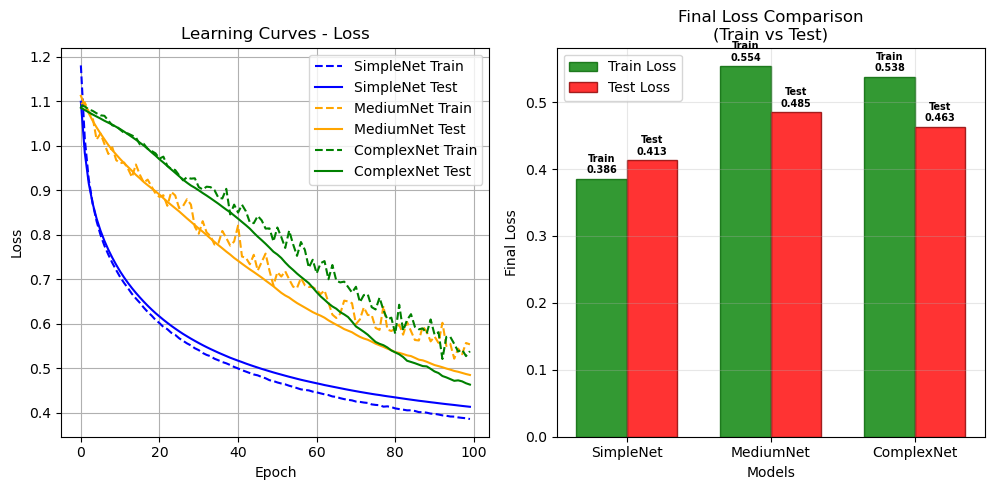


АНАЛИЗ РЕЗУЛЬТАТОВ

ФИНАЛЬНЫЕ ПОТЕРИ:
Модель          Train Loss   Test Loss    Разница   
SimpleNet       0.3857         0.4133         +0.0275
MediumNet       0.5537         0.4848         -0.0688
ComplexNet      0.5382         0.4632         -0.0750


In [4]:
# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

# 1. ОПРЕДЕЛЕНИЕ МОДЕЛЕЙ С РЕГУЛЯРИЗАЦИЕЙ
class SimpleNet(nn.Module):
    """Очень простая однослойная нейросеть"""
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(58, 3)
    
    def forward(self, x):
        return self.layer(x)

class MediumNet(nn.Module):
    """Нейросеть с одним скрытым слоем и регуляризацией"""
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(58, 32)
        self.layer2 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)  
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  
        x = self.layer2(x)
        return x

class ComplexNet(nn.Module):
    """Нейросеть с регуляризацией"""
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(58, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.7)  
        self.dropout2 = nn.Dropout(0.6)  
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x


# 2. УЛУЧШЕННАЯ ФУНКЦИЯ ОБУЧЕНИЯ С РАННЕЙ ОСТАНОВКОЙ
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=100, model_name="", patience=10):
    """Функция для обучения модели с ранней остановкой"""
    train_losses = []
    test_losses = []
    
    model.to(device)
    
    best_test_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    
    for epoch in range(epochs):
        # Обучение
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Валидация
        model.eval()
        test_loss = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        # РАННЯЯ ОСТАНОВКА
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            patience_counter = 0
            best_epoch = epoch
            # Сохраняем лучшую модель
            torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 20 == 0:
            print(f'{model_name} | Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
        
        # Останавливаем если нет улучшений
        if patience_counter >= patience:
            print(f' Ранняя остановка для {model_name} на эпохе {epoch+1}')
            print(f'   Лучший Test Loss: {best_test_loss:.4f} на эпохе {best_epoch+1}')
            break
    
    # Загружаем лучшую модель
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    return train_losses, test_losses

# 3. ОБУЧЕНИЕ МОДЕЛЕЙ
print("=" * 60)
print("ОБУЧЕНИЕ МОДЕЛЕЙ С РЕГУЛЯРИЗАЦИЕЙ")
print("=" * 60)

criterion = nn.CrossEntropyLoss()
epochs = 100

# Модель 1: SimpleNet с SGD
print("\n1. SimpleNet + SGD")
simple_model = SimpleNet()
optimizer_simple = optim.SGD(simple_model.parameters(), lr=0.01, weight_decay=0.001)  
simple_train_loss, simple_test_loss = train_model(
    simple_model, train_loader, test_loader, optimizer_simple, criterion, epochs, "SimpleNet", patience=15
)

# Модель 2: MediumNet с Adam
print("\n2. MediumNet + Adam")
medium_model = MediumNet()
optimizer_medium = optim.Adam(medium_model.parameters(), lr=0.0003, weight_decay=0.01)  # УМЕНЬШИЛИ lr, УВЕЛИЧИЛИ weight_decay
medium_train_loss, medium_test_loss = train_model(
    medium_model, train_loader, test_loader, optimizer_medium, criterion, epochs, "MediumNet", patience=10
)

# Модель 3: ComplexNet с Adam
print("\n3. ComplexNet + Adam")
complex_model = ComplexNet()
optimizer_complex = optim.Adam(complex_model.parameters(), lr=0.0002, weight_decay=0.02)  # УМЕНЬШИЛИ lr, УВЕЛИЧИЛИ weight_decay
complex_train_loss, complex_test_loss = train_model(
    complex_model, train_loader, test_loader, optimizer_complex, criterion, epochs, "ComplexNet", patience=8
)

# 4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\n" + "=" * 50)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("=" * 50)

plt.figure(figsize=(15, 5))

# График потерь
plt.subplot(1, 3, 1)
plt.plot(simple_train_loss, label='SimpleNet Train', linestyle='--', color='blue')
plt.plot(simple_test_loss, label='SimpleNet Test', color='blue')
plt.plot(medium_train_loss, label='MediumNet Train', linestyle='--', color='orange')
plt.plot(medium_test_loss, label='MediumNet Test', color='orange')
plt.plot(complex_train_loss, label='ComplexNet Train', linestyle='--', color='green')
plt.plot(complex_test_loss, label='ComplexNet Test', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves - Loss')
plt.legend()
plt.grid(True)

# График финальных потерь
# График 2: Финальные потери
plt.subplot(1, 3, 2)
models = ['SimpleNet', 'MediumNet', 'ComplexNet']
train_final_loss = [simple_train_loss[-1], medium_train_loss[-1], complex_train_loss[-1]]
test_final_loss = [simple_test_loss[-1], medium_test_loss[-1], complex_test_loss[-1]]

x = range(len(models))
width = 0.35

# Явно разные цвета для train/test
plt.bar([i - width/2 for i in x], train_final_loss, width, 
        label='Train Loss', alpha=0.8, color='green', edgecolor='darkgreen')
plt.bar([i + width/2 for i in x], test_final_loss, width, 
        label='Test Loss', alpha=0.8, color='red', edgecolor='darkred')

plt.xlabel('Models')
plt.ylabel('Final Loss')
plt.title('Final Loss Comparison\n(Train vs Test)')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

# Четкие подписи
for i, (train_loss, test_loss) in enumerate(zip(train_final_loss, test_final_loss)):
    plt.text(i - width/2, train_loss + 0.005, f'Train\n{train_loss:.3f}', 
             ha='center', va='bottom', fontsize=7, fontweight='bold')
    plt.text(i + width/2, test_loss + 0.005, f'Test\n{test_loss:.3f}', 
             ha='center', va='bottom', fontsize=7, fontweight='bold')

# # График разницы потерь (переобучение)
# plt.subplot(1, 3, 3)
# overfitting_gap = [test_final_loss[i] - train_final_loss[i] for i in range(len(models))]
# plt.bar(models, overfitting_gap, color=['blue', 'orange', 'green'], alpha=0.7)
# plt.xlabel('Models')
# plt.ylabel('Test Loss - Train Loss')
# plt.title('Overfitting Gap')
# plt.grid(True, alpha=0.3)

# # Добавляем значения на столбцы
# for i, v in enumerate(overfitting_gap):
#     plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 5. АНАЛИЗ РЕЗУЛЬТАТОВ
print("\n" + "=" * 50)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 50)

print("\nФИНАЛЬНЫЕ ПОТЕРИ:")
print(f"{'Модель':<15} {'Train Loss':<12} {'Test Loss':<12} {'Разница':<10}")

models_data = [
    ('SimpleNet', simple_train_loss[-1], simple_test_loss[-1]),
    ('MediumNet', medium_train_loss[-1], medium_test_loss[-1]),
    ('ComplexNet', complex_train_loss[-1], complex_test_loss[-1])
]

for name, train_loss, test_loss in models_data:
    diff = test_loss - train_loss  
    print(f"{name:<15} {train_loss:.4f}{'':<8} {test_loss:.4f}{'':<8} {diff:+.4f}")



### 7. Расчет метрик Accuracy на train и test множествах

In [5]:
# ФУНКЦИЯ ДЛЯ РАСЧЕТА ACCURACY
def calculate_accuracy(model, dataloader):
    """Вычисляет accuracy для модели на данных из dataloader"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.numpy())
            all_targets.extend(batch_y.numpy())
    
    accuracy = accuracy_score(all_targets, all_predictions)
    return accuracy, all_predictions, all_targets

# РАСЧЕТ ACCURACY ДЛЯ ВСЕХ МОДЕЛЕЙ
print("=" * 50)
print("РАСЧЕТ METRIK ACCURACY НА TRAIN И TEST МНОЖЕСТВАХ")
print("=" * 50)

# SimpleNet
simple_train_acc, simple_train_preds, simple_train_targets = calculate_accuracy(simple_model, train_loader)
simple_test_acc, simple_test_preds, simple_test_targets = calculate_accuracy(simple_model, test_loader)

# MediumNet
medium_train_acc, medium_train_preds, medium_train_targets = calculate_accuracy(medium_model, train_loader)
medium_test_acc, medium_test_preds, medium_test_targets = calculate_accuracy(medium_model, test_loader)

# ComplexNet
complex_train_acc, complex_train_preds, complex_train_targets = calculate_accuracy(complex_model, train_loader)
complex_test_acc, complex_test_preds, complex_test_targets = calculate_accuracy(complex_model, test_loader)

# ВЫВОД РЕЗУЛЬТАТОВ
print(f"\n{'Модель':<15} {'Train Accuracy':<15} {'Test Accuracy':<15} {'Разница':<10}")
print("-" * 60)

models_data = [
    ('SimpleNet', simple_train_acc, simple_test_acc),
    ('MediumNet', medium_train_acc, medium_test_acc),
    ('ComplexNet', complex_train_acc, complex_test_acc)
]

for name, train_acc, test_acc in models_data:
    diff = train_acc - test_acc
    print(f"{name:<15} {train_acc:.4f}         {test_acc:.4f}         {diff:+.4f}")

# ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ
best_model = max(models_data, key=lambda x: x[2])  # максимальный test accuracy
print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model[0]}")
print(f"   Test Accuracy: {best_model[2]:.4f} ({best_model[2]*100:.1f}%)")

print("\n РАСЧЕТ ACCURACY ЗАВЕРШЕН!")

РАСЧЕТ METRIK ACCURACY НА TRAIN И TEST МНОЖЕСТВАХ

Модель          Train Accuracy  Test Accuracy   Разница   
------------------------------------------------------------
SimpleNet       0.8766         0.8734         +0.0032
MediumNet       0.8418         0.8481         -0.0063
ComplexNet      0.7975         0.8228         -0.0253

 ЛУЧШАЯ МОДЕЛЬ: SimpleNet
   Test Accuracy: 0.8734 (87.3%)

 РАСЧЕТ ACCURACY ЗАВЕРШЕН!


### 8. Сравнительный анализ моделей и выводы

In [6]:
# ОТВЕТЫ НА ВОПРОСЫ
print("\n" + "=" * 70)
print("ОТВЕТЫ НА ВОПРОСЫ ЛАБОРАТОРНОЙ РАБОТЫ")
print("=" * 70)

print("\n1. КАКАЯ МОДЕЛЬ СПРАВИЛАСЬ ЛУЧШЕ С ПОСТАВЛЕННОЙ ЗАДАЧЕЙ?")
best_test_acc = max(simple_test_acc, medium_test_acc, complex_test_acc)
if best_test_acc == simple_test_acc:
    best_model_name = "SimpleNet (однослойная нейросеть)"
elif best_test_acc == medium_test_acc:
    best_model_name = "MediumNet (нейросеть с 1 скрытым слоем)"
else:
    best_model_name = "ComplexNet (нейросень с 3+ скрытыми слоями)"

print(f"   Лучшая модель: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.1f}%)")

print("\n2. ИМЕЕТ ЛИ МЕСТО ПЕРЕОБУЧЕНИЕ (OVERFITTING)?")
print("   Анализ разницы между train и test accuracy:")

# Создаем списки для анализа
models = ['SimpleNet', 'MediumNet', 'ComplexNet']
train_accuracies = [simple_train_acc, medium_train_acc, complex_train_acc]
test_accuracies = [simple_test_acc, medium_test_acc, complex_test_acc]
accuracy_gaps = [train_acc - test_acc for train_acc, test_acc in zip(train_accuracies, test_accuracies)]

for i, model in enumerate(models):
    acc_gap = accuracy_gaps[i]
    if acc_gap > 0.05:  # порог для определения переобучения
        status = " ЗНАЧИТЕЛЬНОЕ ПЕРЕОБУЧЕНИЕ"
    elif acc_gap > 0.02:
        status = "  УМЕРЕННОЕ ПЕРЕОБУЧЕНИЕ"
    else:
        status = " МИНИМАЛЬНОЕ ПЕРЕОБУЧЕНИЕ"
    print(f"   {model}: разница = {acc_gap:.4f} - {status}")

print("\n3. ИМЕЕТ ЛИ МЕСТО НЕДООБУЧЕНИЕ (UNDERFITTING)?")
print("   Анализ абсолютных значений accuracy:")
for i, model in enumerate(models):
    test_acc_value = test_accuracies[i]  # Теперь используем список test_accuracies
    if test_acc_value < 0.6:  # порог для определения недообучения
        status = " ВОЗМОЖНОЕ НЕДООБУЧЕНИЕ"
    elif test_acc_value < 0.7:
        status = "  УМЕРЕННАЯ ПРОИЗВОДИТЕЛЬНОСТЬ"
    else:
        status = " ХОРОШАЯ ПРОИЗВОДИТЕЛЬНОСТЬ"
    print(f"   {model}: test accuracy = {test_acc_value:.4f} - {status}")

print("\n4. КАК МОЖНО УЛУЧШИТЬ МЕТРИКИ МОДЕЛЕЙ?")
print("   РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ:")
print("   • Балансировка классов (если распределение неравномерное)")
print("   • Подбор гиперпараметров (learning rate, batch size)")
print("   • Увеличение размера выборки")
print("   • Использование других архитектур (CNN, RNN если уместно)")
print("   • Применение кросс-валидации")
print("   • Использование методов аугментации данных")
print("   • Эксперименты с разными функциями активации")
print("   • Добавление batch normalization")




ОТВЕТЫ НА ВОПРОСЫ ЛАБОРАТОРНОЙ РАБОТЫ

1. КАКАЯ МОДЕЛЬ СПРАВИЛАСЬ ЛУЧШЕ С ПОСТАВЛЕННОЙ ЗАДАЧЕЙ?
   Лучшая модель: SimpleNet (однослойная нейросеть)
   Test Accuracy: 0.8734 (87.3%)

2. ИМЕЕТ ЛИ МЕСТО ПЕРЕОБУЧЕНИЕ (OVERFITTING)?
   Анализ разницы между train и test accuracy:
   SimpleNet: разница = 0.0032 -  МИНИМАЛЬНОЕ ПЕРЕОБУЧЕНИЕ
   MediumNet: разница = -0.0063 -  МИНИМАЛЬНОЕ ПЕРЕОБУЧЕНИЕ
   ComplexNet: разница = -0.0253 -  МИНИМАЛЬНОЕ ПЕРЕОБУЧЕНИЕ

3. ИМЕЕТ ЛИ МЕСТО НЕДООБУЧЕНИЕ (UNDERFITTING)?
   Анализ абсолютных значений accuracy:
   SimpleNet: test accuracy = 0.8734 -  ХОРОШАЯ ПРОИЗВОДИТЕЛЬНОСТЬ
   MediumNet: test accuracy = 0.8481 -  ХОРОШАЯ ПРОИЗВОДИТЕЛЬНОСТЬ
   ComplexNet: test accuracy = 0.8228 -  ХОРОШАЯ ПРОИЗВОДИТЕЛЬНОСТЬ

4. КАК МОЖНО УЛУЧШИТЬ МЕТРИКИ МОДЕЛЕЙ?
   РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ:
   • Балансировка классов (если распределение неравномерное)
   • Подбор гиперпараметров (learning rate, batch size)
   • Увеличение размера выборки
   • Использование других архитекту